# INSTRM-1963 Excluding UNASSIGNED fibers in convergence plot

In [239]:
import re
import subprocess
import numpy as np
from importlib import reload 
import matplotlib.pyplot as plt

from procedures.moduleTest import visDianosticPlot
reload(visDianosticPlot)


<module 'procedures.moduleTest.visDianosticPlot' from '/software/devel/chyan/ics_cobraCharmer/python/procedures/moduleTest/visDianosticPlot.py'>

## Extracting tolerance 

In [65]:
def findToleranceFromVisit(visit):
    command = f"grep moveToPfsDesign /data/logs/actors/fps/2023-*-*.log | grep {visit}"
    output = subprocess.check_output(command, shell=True, text=True)
    slist_str = str(output)
    pattern = r"\{KEY\(tolerance\)=\[Float\((\d+(\.\d+)?)\)\]\}"
    
    match = re.search(pattern, str(slist_str))

    if match:
        value = float(match.group(1))  # Extract the captured numerical value and convert it to float
        #print(value)
    else:
        print("No match found.")
    
    return value

In [67]:
long_string = !grep moveToPfsDesign /data/logs/actors/fps/2023-0[45]-*.log|grep 91068

In [57]:
pattern = r"\{KEY\(tolerance\)=\[Float\((\d+(\.\d+)?)\)\]\}"

In [58]:
match = re.search(pattern, str(long_string))

if match:
    value = float(match.group(1))  # Extract the captured numerical value and convert it to float
    print(value)
else:
    print("No match found.")

0.005


In [66]:
findToleranceFromVisit(93494)

0.005

## Extracting Design ID

In [ ]:
from pfs.utils.fiberids import FiberIds

In [ ]:
fid=FiberIds()


In [141]:
def findDesignFromVisit(visit):
    command = f"grep moveToPfsDesign /data/logs/actors/fps/2023-*-*.log | grep {visit}"
    output = subprocess.check_output(command, shell=True, text=True)
    slist_str = str(output)
    pattern = pattern = r"designId\)=\[Long\((\d+)\)\]"
    match = re.search(pattern, str(slist_str))
    

    if match:
        value = int(match.group(1))  # Extract the captured numerical value and convert it to float
        #print(value)
    else:
        print("No match found.")
    
    return value

In [144]:
pfsDesignID = findDesignFromVisit(93494)

In [185]:
pfsDesignID=2367639813027412121

In [186]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

conn = psycopg2.connect("dbname='opdb' host='db-ics' port=5432 user='pfs'") 
engine = create_engine('postgresql+psycopg2://', creator=lambda: conn)

with conn:
        fiberData = pd.read_sql(f'''
            SELECT DISTINCT 
                fiber_id, pfi_nominal_x_mm, pfi_nominal_y_mm, fiber_status
            FROM pfs_design_fiber
            WHERE
                pfs_design_fiber.pfs_design_id = %(pfsDesignID)s
            -- limit 10
        ''', engine, params={'pfsDesignID': pfsDesignID})


In [187]:
fiberData['cobra_id']=fid.fiberIdToCobraId(fiberData['fiber_id'].values)

In [188]:
fiberData=fiberData.sort_values('cobra_id')
df = fiberData.loc[fiberData['cobra_id'] != 65535]
df

fiber_id  pfi_nominal_x_mm  pfi_nominal_y_mm  fiber_status  cobra_id
363       1955         -9.909947          4.016057             1         1
1877      1956        -11.192557          0.987318             1         2
2043      1957               NaN               NaN             1         3
588       1958        -13.584935         -7.712833             1         4
1926      1959               NaN               NaN             1         5
...        ...               ...               ...           ...       ...
1390       377        179.624222       -112.927811             1      2390
698        378        186.157150       -112.657143             1      2391
1916       379        189.709961       -109.938698             1      2392
2171       380        192.137955       -111.249046             1      2393
34         381        193.717072       -100.282005             1      2394

[2394 rows x 5 columns]

In [226]:
unassigned_rows = df[df[['pfi_nominal_x_mm', 'pfi_nominal_y_mm']].isna().all(axis=1)]
unassigned_cobraIdx =  unassigned_rows['cobra_id'].values - 1 


assigned_row= df[df[['pfi_nominal_x_mm', 'pfi_nominal_y_mm']].notna().all(axis=1)]
assigned_cobraIdx =  assigned_row['cobra_id'].values - 1 

In [236]:
df['pfi_nominal_x_mm'].values+df['pfi_nominal_y_mm'].values*1j

array([ -9.9099474  +4.01605749j, -11.1925573  +0.98731846j,
               nan         +nanj, ..., 189.709961 -109.938698j  ,
       192.137955 -111.249046j  , 193.717072 -100.282005j  ])

In [233]:
newIdx = np.array(list(set(vis.goodIdx).intersection(set(assigned_cobraIdx))))

In [234]:
newIdx

array([   0,    1,    3, ..., 2391, 2392, 2393], dtype=uint16)

In [222]:
len(assigned_cobraIdx)

TypeError: len() of unsized object

In [190]:
newXml = pathlib.Path('/software/mhs/products/Linux64/pfs_instdata/1.6.13/data/pfi/modules/ALL/ALL.xml')

from ics.cobraCharmer import pfiDesign
des = pfiDesign.PFIDesign(newXml)

/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:292: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:294: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:296: RuntimeWarning: divide by zero encountered in divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:292: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:294: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:296: RuntimeWarning: divide by zero encountered in divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


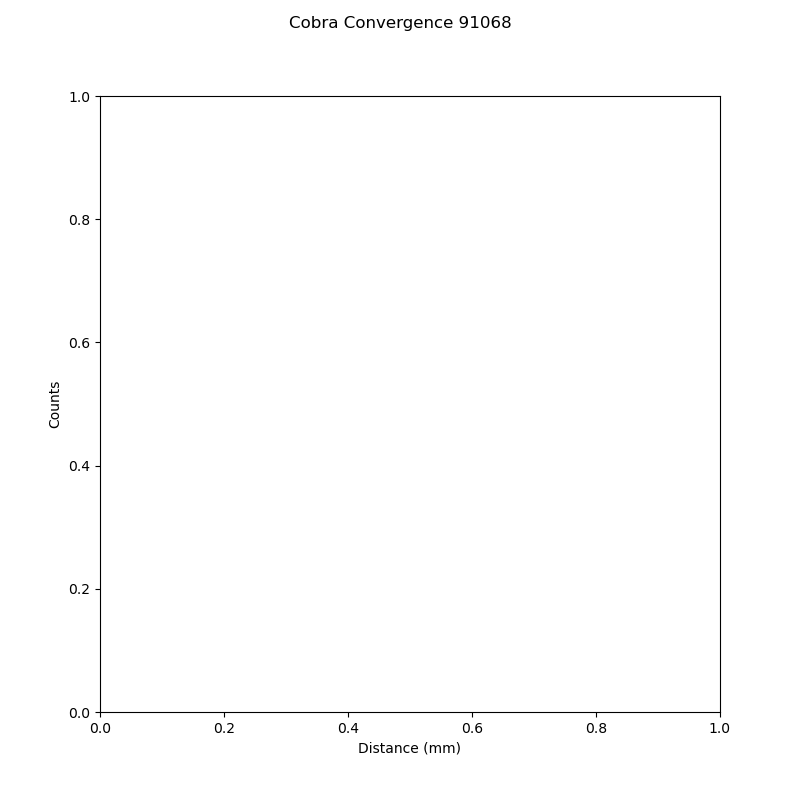

In [207]:
%matplotlib widget
vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=newXml)
vis.visCreateNewPlot(f'Cobra Convergence {visDianosticPlot.findVisit(runDir)}', 'Distance (mm)', 'Counts',size=(8,8))

ax = plt.gca()
ax.set_aspect("equal")
ax.scatter(des.centers.real[assigned_cobraIdx], des.centers.imag[assigned_cobraIdx],marker='o', color='red', s=20)

## Make plot with unassigned fiber excluded 

/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:292: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:294: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:296: RuntimeWarning: divide by zero encountered in divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


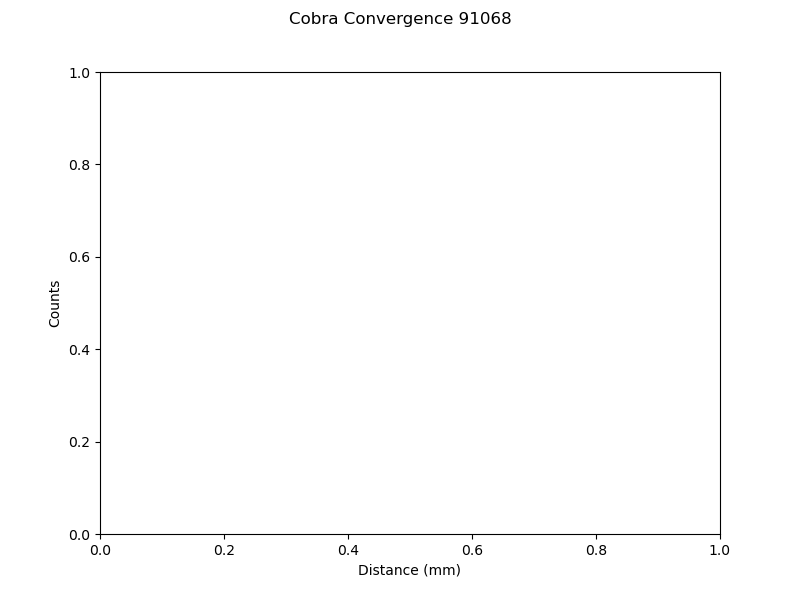

2023-05-31T08:07:54.104 20 visDianosticPlot visDianosticPlot.py:639 Tolerance: 0.01
2023-05-31T08:07:54.122 20 visDianosticPlot visDianosticPlot.py:744 Number of still moving cobra: 1365
2023-05-31T08:07:54.123 20 visDianosticPlot visDianosticPlot.py:745 Number of not done cobra (FPS): 1159


here


In [241]:
%matplotlib widget
import pathlib
newXml = pathlib.Path('/software/mhs/products/Linux64/pfs_instdata/1.6.13/data/pfi/modules/ALL/ALL.xml')
runDir = '20230421_003'
visDianosticPlot.findVisit(runDir)
vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=newXml)
vis.visCreateNewPlot(f'Cobra Convergence {visDianosticPlot.findVisit(runDir)}', 'Distance (mm)', 'Counts',size=(8,6))
vis.visSubaruConvergence(pfsVisitID = visDianosticPlot.findVisit(runDir),subVisit=11,tolerance=0.01, heatmap=True, vmax=0.04, excludeUnassign=True)


/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:292: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:294: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/chyan/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:296: RuntimeWarning: divide by zero encountered in divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


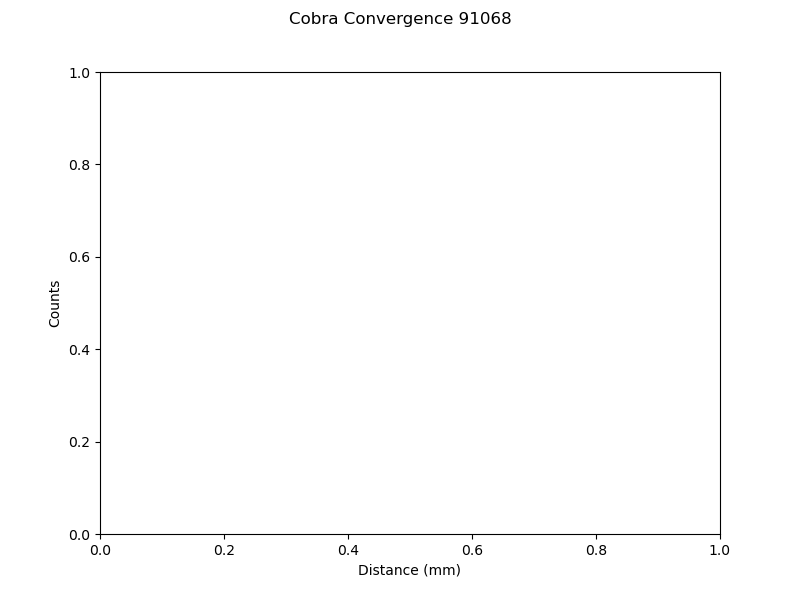

2023-05-31T00:05:16.137 20 visDianosticPlot visDianosticPlot.py:639 Tolerance: 0.01
2023-05-31T00:05:38.504 20 visDianosticPlot visDianosticPlot.py:695 Number of not done cobra (MCS): 1434.0
2023-05-31T00:05:38.506 20 visDianosticPlot visDianosticPlot.py:744 Number of still moving cobra: 1365
2023-05-31T00:05:38.509 20 visDianosticPlot visDianosticPlot.py:745 Number of not done cobra (FPS): 1159


In [240]:
%matplotlib widget
import pathlib
newXml = pathlib.Path('/software/mhs/products/Linux64/pfs_instdata/1.6.13/data/pfi/modules/ALL/ALL.xml')
runDir = '20230421_003'
visDianosticPlot.findVisit(runDir)
vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=newXml)
vis.visCreateNewPlot(f'Cobra Convergence {visDianosticPlot.findVisit(runDir)}', 'Distance (mm)', 'Counts',size=(8,6))
vis.visSubaruConvergence(pfsVisitID = visDianosticPlot.findVisit(runDir),subVisit=3,tolerance=0.01, histo=True, vmax=0.04, excludeUnassign=True)


In [232]:
assigned_cobraIdx

array([   0,    1,    3, ..., 2391, 2392, 2393], dtype=uint16)

In [157]:
len(unassigned_cobraIdx)

102

In [123]:
len(assigned.pfiNominal)

2356

In [85]:
fid.fiberIdToCobraId(fiberData['fiber_id'].values)

array([ 676,  491, 1275, ...,  724, 2099, 1015], dtype=uint16)

In [93]:
string = !find /data/MCS/2023* |grep 93494

In [104]:
def findRunDir(pfsVisitId):
    command = f"find /data/MCS/2023* |grep {pfsVisitId}"
    output = subprocess.check_output(command, shell=True, text=True)
    return output.split('\n')[0][10:22]


In [105]:
findRunDir(93494)

'20230502_018'

In [101]:
pfsVisitId = 93494
command = f"find /data/MCS/2023* |grep {pfsVisitId}"
output = subprocess.check_output(command, shell=True, text=True)


In [103]:
output.split('\n')

['/data/MCS/20230502_018/data/PFSC09349410.fits',
 '/data/MCS/20230502_018/data/PFSC09349408.fits',
 '/data/MCS/20230502_018/data/PFSC09349400.fits',
 '/data/MCS/20230502_018/data/PFSC09349404.fits',
 '/data/MCS/20230502_018/data/PFSC09349401.fits',
 '/data/MCS/20230502_018/data/PFSC09349405.fits',
 '/data/MCS/20230502_018/data/PFSC09349411.fits',
 '/data/MCS/20230502_018/data/PFSC09349409.fits',
 '/data/MCS/20230502_018/data/PFSC09349403.fits',
 '/data/MCS/20230502_018/data/PFSC09349407.fits',
 '/data/MCS/20230502_018/data/PFSC09349412.fits',
 '/data/MCS/20230502_018/data/PFSC09349402.fits',
 '/data/MCS/20230502_018/data/PFSC09349406.fits',
 '']